--------------
**Visualisation of Subnetworks**

Purpose of this notebook:
- build a visualisation for each subnetwork. This will lay the foundation for a web-based app as part of the productionised AML solution which then is a search-type interface for different visualisations.

Process to build the sub-network visualisation:
- use networkx for visualisation of illicit subgraphs.

Notes:
- think about whether licit nodes should be visualised as part of the illicit sub-network??

--------------

In [1]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# GCP libraries
from pandas_gbq import to_gbq # write pandas df to a GCP BigQuery table
import gcsfs
import importlib.util
import os
import inspect

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


--------------
##### Read in Txn Subnetwork Classes & Modules
--------------


In [84]:
# Define bucket and file path
bucket_name = "thesis_classes"
file_name = "txn_subnetworks.py"
gcs_path = f"gs://{bucket_name}/{file_name}"

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Local filename to save the script temporarily
local_file = f"/tmp/{file_name}"

# Download the file from GCS to local storage
fs.get(gcs_path, local_file)

# Dynamically import the module
module_name = "txn_subnetworks"
spec = importlib.util.spec_from_file_location(module_name, local_file)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [85]:
# Use inspect to get classes and functions
classes = [name for name, obj in inspect.getmembers(module, inspect.isclass)]

# Print results
print("Classes in module:")
for cls in classes:
    print(f"  - {cls}")


Classes in module:
  - Line2D
  - build_txn_subnetwork
  - combinations
  - defaultdict
  - reporting
  - visualise_subnetwork


In [86]:
# Instantiate the classes
build_vis = module.visualise_subnetwork()
build_report = module.reporting()

--------------
##### Read in Datasets
--------------


In [5]:
# Get subnetwork edges table
%%bigquery df_network_edges
select * from `extreme-torch-467913-m6.networks.network_edges_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
df_network_edges.head(1)

,merged_subnetwork_id,src_txn_id,dst_txn_id,min_src_hop,min_dst_hop
0,0,3084073,230658142,0,1


In [34]:
# Get subnetwork rank table
%%bigquery df_txn_rank
select * from `extreme-torch-467913-m6.networks.network_txn_rank`;

Query is running:   0%|          |

Downloading:   0%|          |

In [35]:
df_txn_rank.head(1)

,merged_subnetwork_id,node,in_BTC_total,in_txs_degree,out_txs_degree,pagerank,pagerank_pct,pagerank_pct_filled_for_contrib,in_btc_pct,in_deg_pct,out_deg_pct,out_deg_pct_inv,in_btc_share,pr_weight,val_weight,in_weight,out_weight,pr_contrib,val_contrib,in_deg_contrib,out_deg_contrib,composite_raw,composite_pct,composite_rank,pagerank_missing,pr_rank,hub_score,authority_score,hub_rank,authority_rank,rank_inDeg,rank_outDeg,betweenness,harmonic,eigenvector,katz,coreness,rank_betw,rank_harm,rank_eig,rank_katz,rank_coreness,hop
0,27227,163867600,2.7220,1,0,0.0056,0.6503,0.6503,0.0055,0.5055,0.0055,0.9945,0.0037,0.6000,0.3000,0.0700,0.0300,0.3902,0.0016,0.0354,0.0298,0.4570,0.3443,121,False,1.0000,0.0000,-0.0083,93.0000,114.0000,1.0000,1.0000,0.0000,5.7840,0.0018,0.0740,1.0000,92.0000,1.0000,182.0000,1.0000,1.0000,182


In [9]:
# Get address txn edgelist
%%bigquery df_addrtxn
select * from `extreme-torch-467913-m6.actor.addrtxn_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
df_addrtxn.head(1)

,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127


In [11]:
# Get txn address edgelist
%%bigquery df_txnaddr
select * from `extreme-torch-467913-m6.actor.txaddr_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
df_txnaddr.head(1)

,txId,output_address
0,230325127,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH


In [13]:
# Get nw summary table
%%bigquery df_nw_summary
select * from `extreme-torch-467913-m6.networks.network_summary`;

Query is running:   0%|          |

Downloading:   0%|          |

In [14]:
df_nw_summary.head(1)

,merged_subnetwork_id,txn_ids,node_count,edge_count,depth,seeds,seed_count,linked_txn_count
0,17742,"[101586718, 130897027, 138779422, 162026612, 1...",394,438,15,"[130897027, 176149522, 298005149, 306112320, 3...",223,171


--------------
##### Build txn-txn subnetwork visualisation
--------------


In [57]:
subnetwork_filter = 0
df_nw_summary[df_nw_summary['merged_subnetwork_id']==subnetwork_filter]

,merged_subnetwork_id,txn_ids,node_count,edge_count,depth,seeds,seed_count,linked_txn_count
92,0,"[3084073, 9907558, 27405707, 36385394, 3991527...",31,31,2,"[3084073, 9907558, 36385394, 39915271, 2303317...",26,5


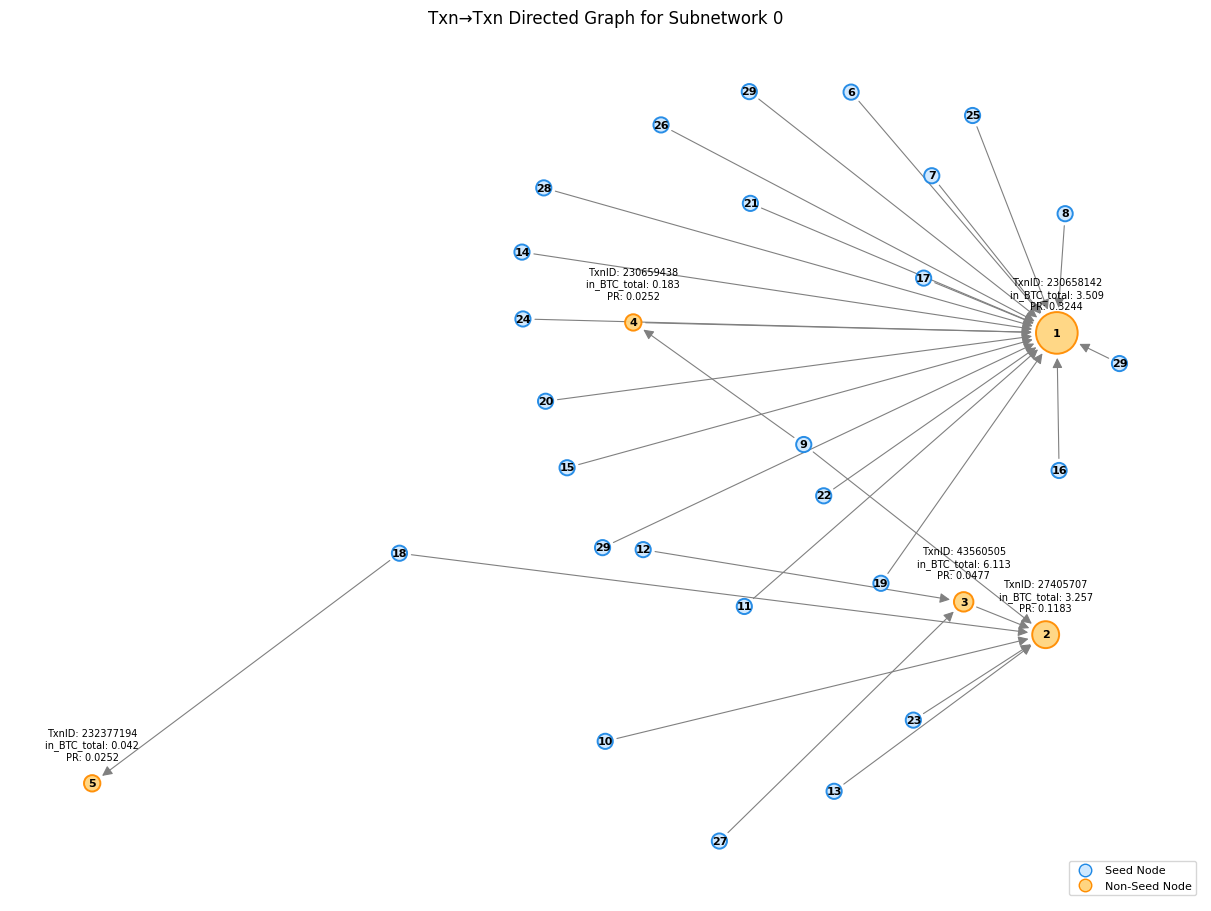

In [58]:
G = build_vis.plot_txntxn_subnetwork(
    df_network_edges,
    df_txn_rank,
    subnetwork_id=0,
    size_by="pagerank",     # ensure size is composite %
    label_by="composite_rank",   # ensure centre label is composite rank
    top_n_label=5
)


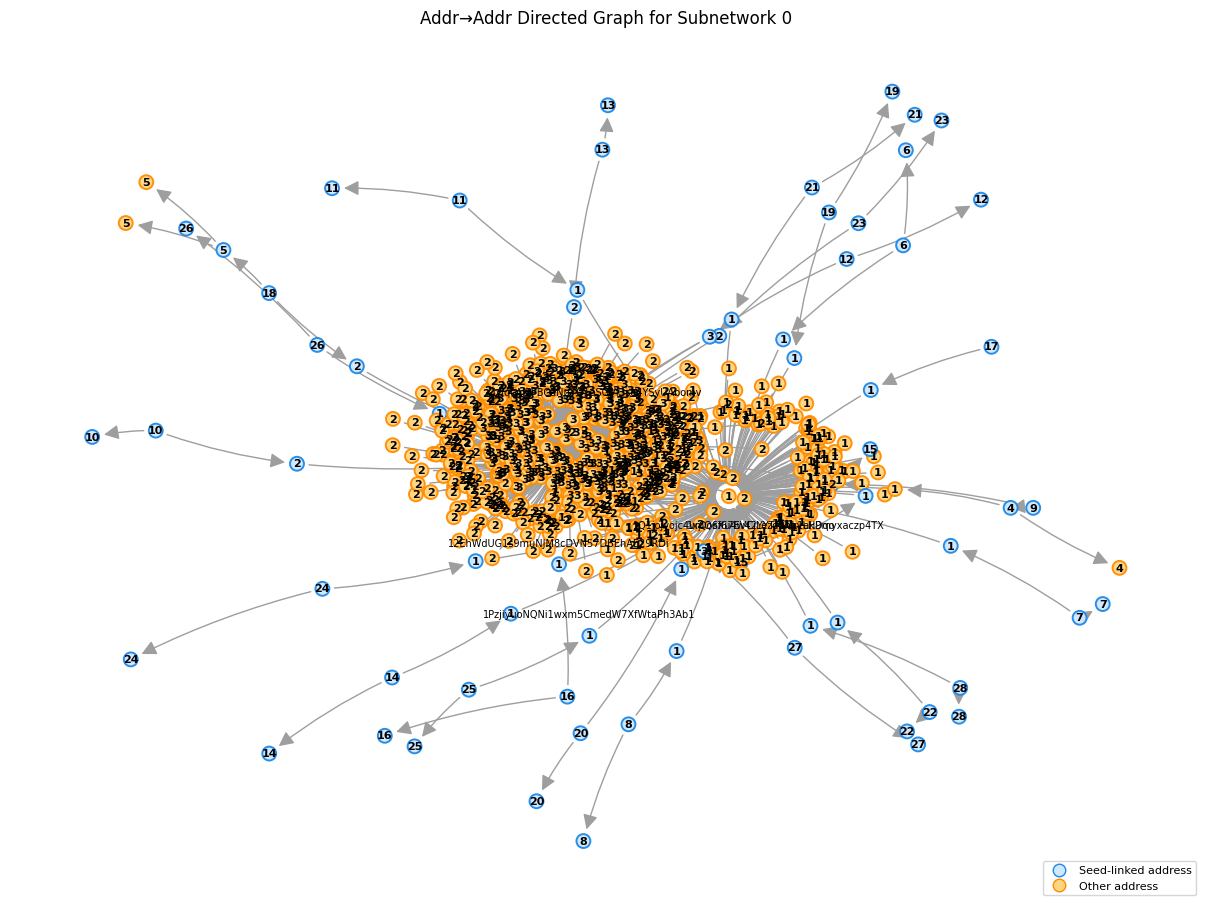

In [87]:
G = build_vis.plot_addraddr_subnetwork(
    df_addrtxn, df_txnaddr, df_txn_rank, df_network_edges,
    merged_subnetwork_id=subnetwork_filter,
    uniform_size=True,     # ignore pagerank, make all nodes same size
    others_size=100,
    top_n_label=5,
    k=1.1
)

--------------
##### Build Investigation Summary Tables

--------------

This section builds summary tables to assist investigators prioritise alerts by subnetwork.

Add in summary with count of txn per address.


In [ ]:
summary_table = build_report.build_subnetwork_viz_summary(df_rank, df_addrtxn, df_txnaddr, join_to_string=True)
summary_table.head()

,subnetwork_id,txn_id,illicit_flag,seed_flag,investigation_order,in_BTC_total,node_score,input_addresses,output_addresses,n_inputs,n_outputs
0,0,230658142,True,False,1,3.5091,0.3630,125AS1eUZkjPNayhHEt2KLiHVzqZ5jExT1; 12ATFXLSx7...,1XFR1USgYp7gDHPhuNfqVjGF2hcKyLxo2,248,1
1,0,27405707,True,False,2,3.2574,0.2174,115Zkr1WmRWTqUoMvvMnyFVmiBcuo7b9QD; 115c96NaBJ...,3J1MmSusQRs7b4XA6hxK37t6PYK5gwf3VH,382,1
2,0,43560505,True,False,3,6.1129,0.2146,112hDfLPx3gGzUWVBmzfhNeeEtet4NW56G; 113X4nQpfK...,1KXepBmv9L2LsSxscaoi1Cr8XHazzK44T9; 36fFx8qprB...,380,2
3,0,232377194,True,False,4,0.0416,0.0558,14MhC6hhUGePGZgNUhuk3YLtwoGZTAPRp4,1FrVYLBRPrmZ3bpeWX6SXYaY73fZpzYeM9; 1NDe8tkEPE...,1,2
4,0,3084073,True,False,5,0.0000,0.0406,,,0,0


See Network Address

In [ ]:
summary_table[summary_table['subnetwork_id']==27983]

,subnetwork_id,txn_id,illicit_flag,seed_flag,investigation_order,in_BTC_total,node_score,input_addresses,output_addresses,n_inputs,n_outputs
17451,27983,136453004,True,False,1,0.0750,0.1433,3Fo2Q9Q6VWpn48o3wbdU4Q8oyV3oDEHSeg; 3Jcx7HCrsJ...,17w9U44CTXi92PeS3aXvV6FYLtvW742caQ; 3Jcx7HCrsJ...,2,2
17452,27983,298953494,True,False,2,0.0279,0.1238,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,1LX1yqrs88dsD3jiupWgR2kL3hvEGmFQYe; 3Jcx7HCrsJ...,1,2
17453,27983,298952804,True,False,3,0.0916,0.1213,39XG2oYj1rAGhfEd9LG1DNufFmZ4p9rQe9; 3Fo2Q9Q6VW...,1CgsrNQPuQkd8H6MT5LaEQuuwoaVXa94uE; 3Fo2Q9Q6VW...,2,2
17454,27983,298953159,True,False,4,0.0643,0.1149,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,1HMXCLg3FR8uxDruVXj9PEcyjxJ8TJN6L3; 3Jcx7HCrsJ...,1,2
17455,27983,180048665,True,False,5,0.0651,0.1148,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,1KxcVJhStrncx7Rp9QXVjHFbpZQNswP5En; 3Jcx7HCrsJ...,1,2
17456,27983,255745729,True,False,6,0.0602,0.1139,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,1Mv2QivJDknn2ZiRVC48peFcg8W8DHXXmz; 3Jcx7HCrsJ...,1,2
17457,27983,298953168,True,False,7,0.0508,0.1113,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,1BXmVC6S2USATRf63bTVuHsTUEHvrond3Z; 3Jcx7HCrsJ...,1,2
17458,27983,260763400,True,False,8,0.0454,0.1098,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,36dDfDJHrXYUmdbnbpNHWSemTeqPkM4GRS; 3Jcx7HCrsJ...,1,2
17459,27983,273741517,True,False,9,0.0405,0.1086,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT; 3KM921nHec...,1,2
17460,27983,269143173,True,False,10,0.0318,0.1060,3Jcx7HCrsJFfhm4NDWGnUxX2zCyK8GVGdT,342iAiRdBFV6rgbfVjcGtiC8tUGMxHgTez; 3Jcx7HCrsJ...,1,2


END